# Using ray

This notebook will fetch data from ServiceX and process it via coffea on a local `ray` cluster.

In [1]:
from make_it_sync import make_sync
import matplotlib.pyplot as plt
from coffea import hist, processor

import sys
sys.path += ['..']
from sx_multi import FuncAdlQastle, sx_event_stream, process_coffea_ray

# Fetching the data

We want to pull back only electrons with $p_T > 30$ GeV, and $abs(\eta)<2.5$. Aid since this is a super-simple algorithm - we will limit it to those events that have just two electrons.

In [2]:
ds = FuncAdlQastle()
leptons_per_event_query = ds \
        .Select(lambda e: e.Electrons("Electrons")) \
        .Select(lambda eles: eles.Where(lambda e: e.pt()/1000.0 > 30.0)) \
        .Select(lambda eles: eles.Where(lambda e: abs(e.eta()) < 2.5)) \
        .Where(lambda eles: len(eles) == 2) \
        .Select(lambda ls: (ls.Select(lambda e: e.pt()/1000.0), ls.Select(lambda e: e.eta()), ls.Select(lambda e: e.phi()), ls.Select(lambda e: e.m()/1000.0))) \
        .AsROOTTTree('data.root', 'mytree', ('ElePt', 'EleEta', 'ElePhi', 'EleM'))

And the dataset identifier we want to be scanning:

In [3]:
did = 'mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00'

# Define Coffea Process Function

This will get the data from above (in servicex). It gets access to a single file and must open it, and then build the invar mass.

In [4]:
accumulator = processor.dict_accumulator({
    "sumw": processor.defaultdict_accumulator(float),
    "mass": hist.Hist(
        "Events",
        hist.Cat("dataset", "Dataset"),
        hist.Bin("mass", "$Z_{ee}$ [GeV]", 60, 60, 120),
    ),
})

In [5]:
def zmass_process(events_url, tree_name, accumulator):
    '''Process a single file of electorn data into an invarient mass peak

    - Look only at files with exactly 2 electrons
    - Make no further cuts

    Arguments:
      events_url: a URL to a ROOT file that uproot4 can open
      tree_name: The tree in the ROOT file to use for our data
      accumulator: coffea accumulator to place data we are building in.
    '''
    # Since we execute remotely, explicitly include everything we need.
    import awkward1 as ak
    from coffea.nanoevents import NanoEventsFactory
    from coffea.nanoevents import BaseSchema

    # This in is amazingly important - the invar mass will fail silently without it.
    # And must be done in here as this function is shipped off to the funcx processor
    # on a remote machine/remote python environment.
    from coffea.nanoevents.methods import candidate
    ak.behavior.update(candidate.behavior)

    # Use NanoEvents to build a 4-vector
    events = NanoEventsFactory.from_file(
        file=str(events_url),
        treepath=f'/{tree_name}',
        schemaclass=BaseSchema,
        metadata={
            'dataset': 'mc15x',
            'filename': str(events_url)
        }
    ).events()

    dataset = events.metadata['dataset']
    electrons = ak.zip({
        "pt": events.ElePt,
        "eta": events.EleEta,
        "phi": events.ElePhi,
        "mass": events.EleM,
        "charge": events.EleM,
    }, with_name="PtEtaPhiMCandidate")

    # The template of the output we will send back.
    output = accumulator.identity()

    # Do the buts, form the invar mass, plot.
    cut = (ak.num(electrons) == 2)
    diele = electrons[cut][:, 0] + electrons[cut][:, 1]

    output["sumw"][dataset] += len(events)
    output["mass"].fill(
        dataset=dataset,
        mass=diele.mass,
    )

    return output

# Run through ray

First, the data stream from servicex.

In [6]:
servicex_data = sx_event_stream(did, leptons_per_event_query)

Create a local `ray` cluster. We'll setup 10 workers, but there is probably a better way to tune this.

In [7]:
import ray
ray.init(ignore_reinit_error=True)

2020-11-14 03:55:11,072	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265
2020-11-14 03:55:11,077	WARNING services.py:1560 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


{'node_ip_address': '10.1.0.60',
 'raylet_ip_address': '10.1.0.60',
 'redis_address': '10.1.0.60:6379',
 'object_store_address': '/tmp/ray/session_2020-11-14_03-55-10_690163_2218/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-11-14_03-55-10_690163_2218/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-11-14_03-55-10_690163_2218',
 'metrics_export_port': 56794,
 'node_id': 'be62baee8ceb037ceb8d8a923b1ee0f0aed200a9'}

This will now run each sx resulting file through the processor above

In [8]:
accumulated_results = process_coffea_ray(servicex_data,
                                          zmass_process,
                                          accumulator)

Plot - attempt to update the plot as it comes in (but don't know how to do that!)

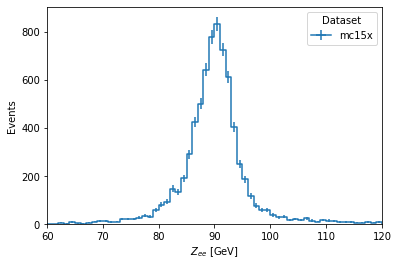

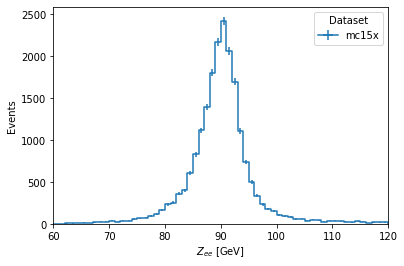

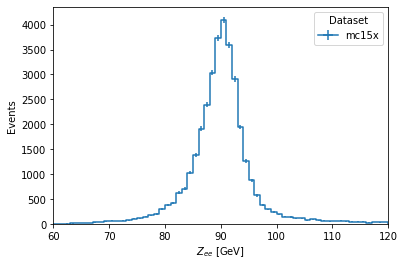

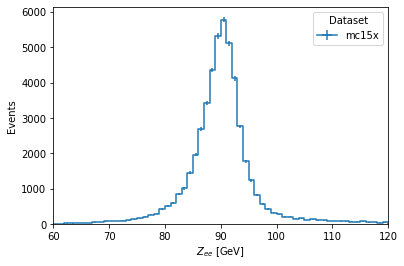

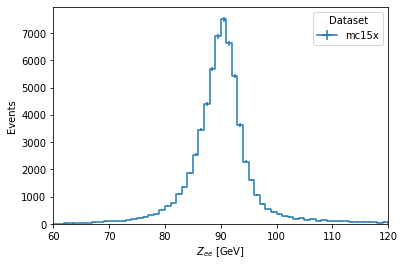

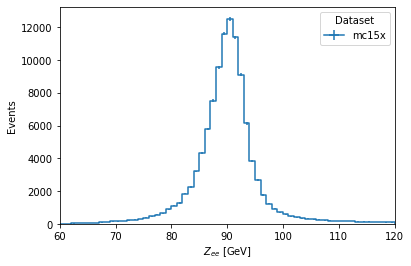

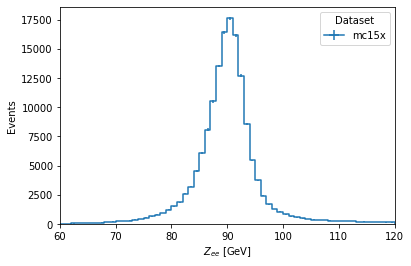

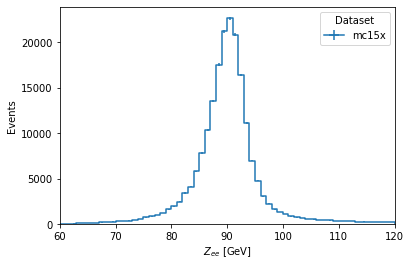

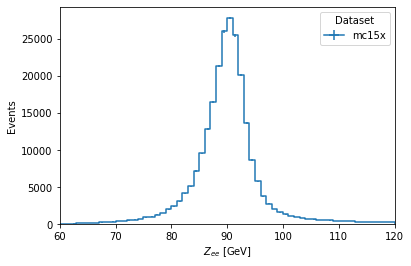

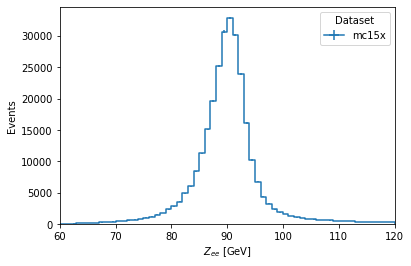

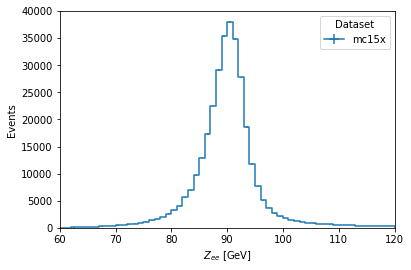

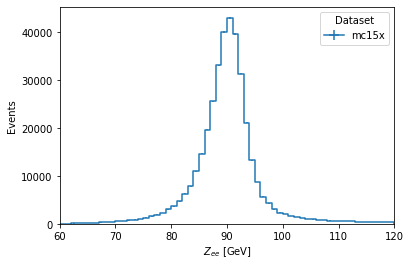

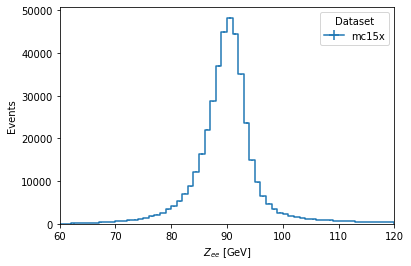

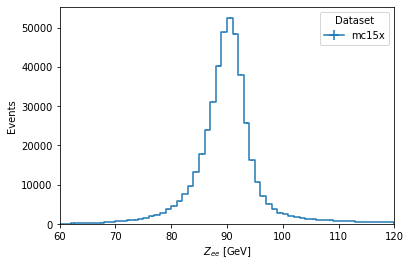

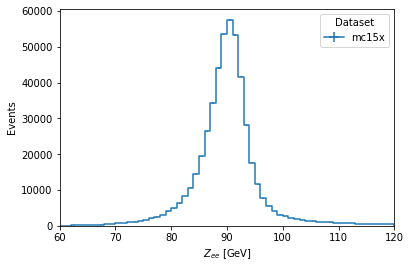

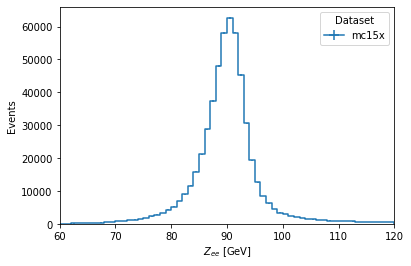

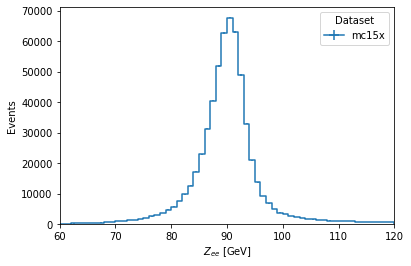

{'sumw': defaultdict_accumulator(float, {'mc15x': 1993800.0}),
 'mass': <Hist (dataset,mass) instance at 0x7fa919516510>}

In [9]:
async def plot_stream(accumulator_stream):
  async for coffea_info in accumulator_stream:
    # Need to ask coffea folks how to anomate this!
    hist.plot1d(coffea_info['mass'])
    plt.show()
  return coffea_info

await plot_stream(accumulated_results)

In this demo, the data is produced on UChicago's `river` cluster and downloaded locally to where this notebook is running (for the above, this is a house in Canada). Watching my network connection, even with 10 workers, it isn't saturated. And is definately slower than the `funcx`. However, if there was a `ray` cluster located on `river`, one could connect there and then the same efficiencies seen with `funcx` would be seen here.